In [1]:
import stompy.model.delft.dflow_model as dfm
import pesca_base
import xarray as xr
import matplotlib.pyplot as plt
from stompy.plot import plot_wkb
import six
from stompy import utils, filters
import numpy as np
%matplotlib notebook

In [14]:
def local_max(da,t,dt=np.timedelta64(3,'h')):
    ti=np.searchsorted(da.time,t)
    V=da.values
    while ti>0 and ti<len(V)-1:
        if V[ti+1]>V[ti]:
            ti+=1
        elif V[ti-1]>V[ti]:
            ti-=1
        else:
            break
    da=da.isel(time=ti)
    if da.time<t-dt or da.time>t+dt:
        raise Exception("Max not found within window")
    return da

In [15]:
# p03 is a breach
#run_dir="/media/cws/hydro/Pescadero/Model_Runs/Production/run_tide_test-p03"
# p06 also a breach
#run_dir="/media/cws/hydro/Pescadero/Model_Runs/Production/run_tide_test-p06"
#run_dir="/media/cws/hydro/Pescadero/Model_Runs/Production/run_tide_test-p05" # breach

#run_dir="/media/cws/hydro/Pescadero/Model_Runs/Production/run_tide_test-p08" # 2017-07 tidal
run_dir="run_tide_test-p08" # 2017-07 tidal
model=pesca_base.PescaButano.load(run_dir)

In [16]:
# Linux run has bad geometry for cross sections.
his_ds=model.his_dataset()
his_ds

Yuck - duplicate cross section names
Some lines are degenerate


<xarray.Dataset>
Dimensions:                                       (cross_section: 11, cross_section_geom_nNodes: 22, general_structures: 2, nFlowElemContourPts: 4, nFlowElemWithBnd: 5517, nFlowLink: 8749, nFlowLinkPts: 2, nNetLink: 9000, nNetLinkPts: 2, source_sink: 2, source_sink_geom_nNodes: 4, source_sink_pts: 3, station_geom_nNodes: 515, stations: 515, time: 1537)
Coordinates:
    station_x_coordinate                          (stations) float64 ...
    station_y_coordinate                          (stations) float64 ...
    station_name                                  (stations) |S64 b'pch_up' ....
    cross_section_name                            (cross_section) |S64 b'mout...
    source_sink_name                              (source_sink) |S64 ...
    general_structure_id                          (general_structures) |S64 ...
  * time                                          (time) datetime64[ns] 2017-...
  * cross_section                                 (cross_section) <U15 'mouth...
  * stations                                      (stations) <U18 'pch_up' .....
Dimensions without coordinates: cross_section_geom_nNodes, general_structures, nFlowElemContourPts, nFlowElemWithBnd, nFlowLink, nFlowLinkPts, nNetLink, nNetLinkPts, source_sink, source_sink_geom_nNodes, source_sink_pts, station_geom_nNodes
Data variables:
    FlowElem_xcc                                  (nFlowElemWithBnd) float64 ...
    FlowElem_ycc                                  (nFlowElemWithBnd) float64 ...
    FlowElem_zcc                                  (nFlowElemWithBnd) float64 ...
    FlowElem_bac                                  (nFlowElemWithBnd) float64 ...
    FlowElem_xzw                                  (nFlowElemWithBnd) float64 ...
    FlowElem_yzw                                  (nFlowElemWithBnd) float64 ...
    FlowElemContour_x                             (nFlowElemWithBnd, nFlowElemContourPts) float64 ...
    FlowElemContour_y                             (nFlowElemWithBnd, nFlowElemContourPts) float64 ...
    FlowElem_bl                                   (nFlowElemWithBnd) float64 ...
    ElemLink                                      (nNetLink, nNetLinkPts) int32 ...
    FlowLink                                      (nFlowLink, nFlowLinkPts) int32 ...
    FlowLinkType                                  (nFlowLink) int32 ...
    FlowLink_xu                                   (nFlowLink) float64 ...
    FlowLink_yu                                   (nFlowLink) float64 ...
    projected_coordinate_system                   int32 ...
    FlowLink_lonu                                 (nFlowLink) float64 ...
    FlowLink_latu                                 (nFlowLink) float64 ...
    FlowElemDomain                                (nFlowElemWithBnd) int32 ...
    FlowLinkDomain                                (nFlowLink) int32 ...
    FlowElemGlobalNr                              (nFlowElemWithBnd) int32 ...
    station_id                                    (stations) |S64 ...
    station_geom                                  int32 ...
    station_geom_node_count                       (stations) int32 ...
    station_geom_node_coordx                      (station_geom_nNodes) float64 ...
    station_geom_node_coordy                      (station_geom_nNodes) float64 ...
    waterlevel                                    (time, stations) float64 ...
    bedlevel                                      (stations) float64 ...
    x_velocity                                    (time, stations) float64 ...
    y_velocity                                    (time, stations) float64 ...
    taus                                          (time, stations) float64 ...
    cross_section_geom                            (cross_section) object None...
    cross_section_geom_node_count                 (cross_section) int32 0 ... 0
    cross_section_geom_node_coordx                (cross_section_geom_nNodes) float64 ...
    cross_section_geom_node_coordy            

In [17]:
factors=np.ones(his_ds.dims['cross_section'])
for xs in ['n_complex_xs']:
    factors[his_ds.cross_section.values=='n_complex_xs']=-1
    
his_ds['cross_section_discharge'] *= factors
his_ds['cross_section_cumulative_discharge'] *= factors
his_ds['cross_section_velocity'] *= factors
    

<IPython.core.display.Javascript object>


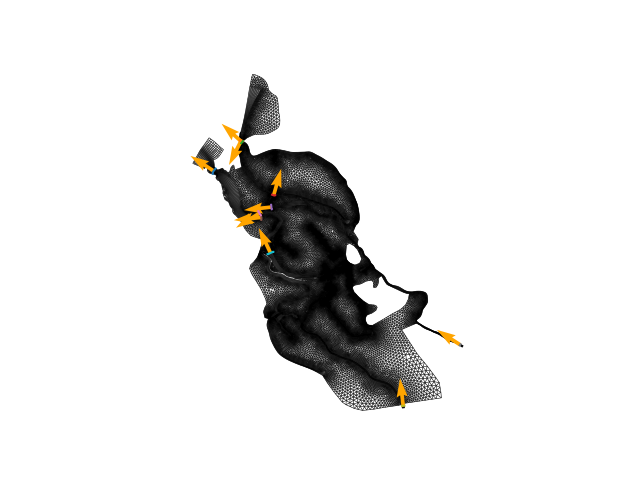

In [109]:
# Check on the sign of the cross sectionsma

# In the plot below, all arrows should be pointing
# downstream. So far this is true for all but PCH.
# Note that the flipping above does *not* flip the
# geometry
plt.figure()
model.grid.plot_edges(lw=0.4,color='k')
plt.axis('off')
plt.axis('tight')
plt.axis('equal')

XY=[]
UV=[]

for xs in his_ds.cross_section.values:
    geom=his_ds.cross_section_geom.sel(cross_section=xs).item()
    plot_wkb.plot_wkb(geom)
    # Which way is the normal pointing?
    pA=np.array(geom.interpolate(0.5,normalized=1))
    pB=np.array(geom.interpolate(0.6,normalized=1))
    
    tang=pB-pA
    right=utils.to_unit(np.r_[tang[1],-tang[0]])
    XY.append(pA)
    UV.append(50*right)
    
XY=np.array(XY)
UV=np.array(UV)
plt.quiver(XY[:,0],XY[:,1],UV[:,0],UV[:,1],color='orange',zorder=2)

In [18]:
# Based on NCK waterlevel predictions
spring_high=np.datetime64('2017-07-23 05:30')
spring_low =np.datetime64('2017-07-23 16:15')
neap_high  =np.datetime64('2017-07-28 23:00')
neap_low   =np.datetime64('2017-07-29 07:30')

<IPython.core.display.Javascript object>


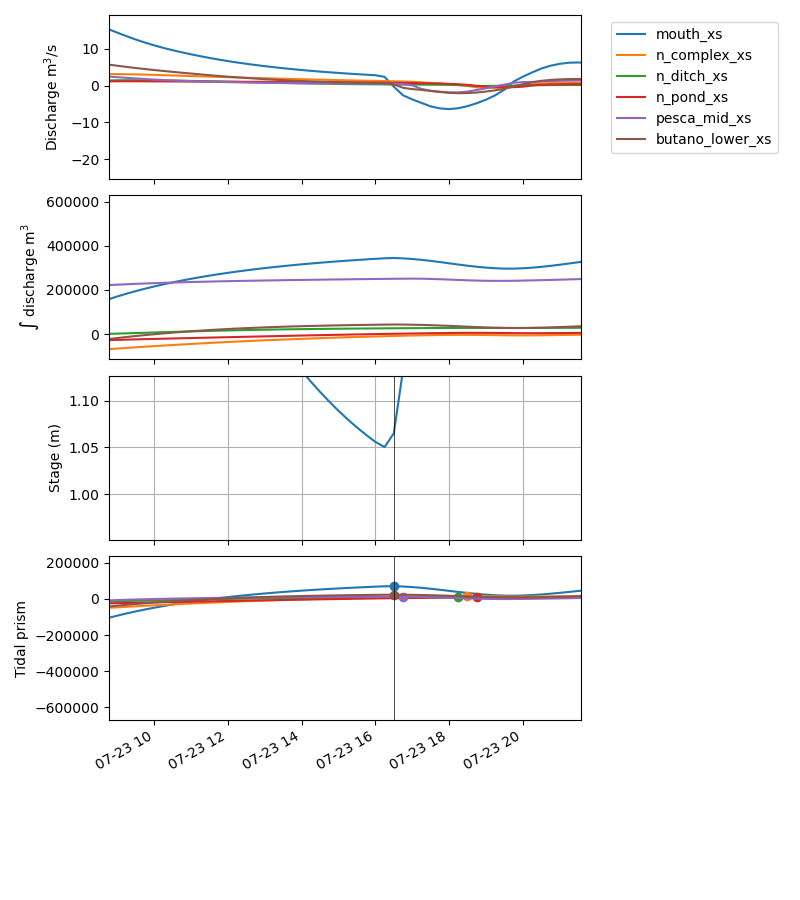

mouth_xs
  Spring tide tidal prism:   292750 m^3   237.3 ac-ft
    Neap tide tidal prism:   106032 m^3    86.0 ac-ft
n_complex_xs
  Spring tide tidal prism:    77100 m^3    62.5 ac-ft
    Neap tide tidal prism:    17260 m^3    14.0 ac-ft
n_ditch_xs
  Spring tide tidal prism:    25897 m^3    21.0 ac-ft
    Neap tide tidal prism:     3719 m^3     3.0 ac-ft
n_pond_xs
  Spring tide tidal prism:    37340 m^3    30.3 ac-ft
    Neap tide tidal prism:    10281 m^3     8.3 ac-ft
pesca_mid_xs
  Spring tide tidal prism:    43675 m^3    35.4 ac-ft
    Neap tide tidal prism:    27969 m^3    22.7 ac-ft
butano_lower_xs
  Spring tide tidal prism:   110492 m^3    89.6 ac-ft
    Neap tide tidal prism:    34215 m^3    27.7 ac-ft


In [167]:
fig,axs=plt.subplots(4,1,sharex=True,figsize=(8,9))

for section in ['mouth_xs','n_complex_xs','n_ditch_xs','n_pond_xs',
                'pesca_mid_xs','butano_lower_xs']:
    if 1: # plot time series
        axs[0].plot(his_ds.time,his_ds['cross_section_discharge'].sel(cross_section=section),label=section)
        axs[1].plot(his_ds.time,his_ds['cross_section_cumulative_discharge'].sel(cross_section=section),label=section)

        Qnet=his_ds['cross_section_cumulative_discharge'].sel(cross_section=section)
        Qnet_lp=filters.lowpass(Qnet,utils.to_dnum(his_ds.time.values),cutoff=3.5)
        Qnet_hp=Qnet-Qnet_lp
        ls=axs[3].plot(his_ds.time, Qnet_hp,label=section)
    
    if 1: # calculate max prism
        spring_high_da=-local_max(-Qnet_hp,spring_high)
        spring_low_da =local_max(Qnet_hp,spring_low)
        neap_high_da  =-local_max(-Qnet_hp,neap_high)
        neap_low_da   =local_max(Qnet_hp,neap_low)

        spring_dV=spring_low_da.values - spring_high_da.values
        neap_dV=neap_low_da.values - neap_high_da.values
        print(section)
        m3_to_acft=0.000810714
        print(f"  Spring tide tidal prism: {spring_dV:8.0f} m^3  {spring_dV*m3_to_acft:6.1f} ac-ft")
        print(f"    Neap tide tidal prism: {  neap_dV:8.0f} m^3  {neap_dV*m3_to_acft:6.1f} ac-ft")
        das=[spring_high_da,spring_low_da,neap_high_da,neap_low_da]
        t=[da.time.values for da in das]
        z=[da.values for da in das]
        axs[3].plot(t,z,marker='o',color=ls[0].get_color(),lw=0.0,label='__nolabel__')    
    
axs[0].set_ylabel('Discharge m$^3$/s')
axs[1].set_ylabel(r'$\int$ discharge m$^3$')
axs[2].plot(his_ds.time, his_ds['waterlevel'].sel(stations='nck'))
axs[3].set_ylabel('Tidal prism')

axs[2].set_ylabel('Stage (m)')


for da in [spring_high_da, spring_low_da, neap_high_da, neap_low_da]:
    axs[2].axvline(da.time.values,color='k',lw=0.5)
    axs[3].axvline(da.time.values,color='k',lw=0.5)

axs[0].legend(loc='upper left',bbox_to_anchor=[1.05,1.0])
fig.tight_layout()
fig.autofmt_xdate()

In [20]:
map_ds=xr.open_dataset(model.map_outputs()[0])
#map_ds.close()

<IPython.core.display.Javascript object>


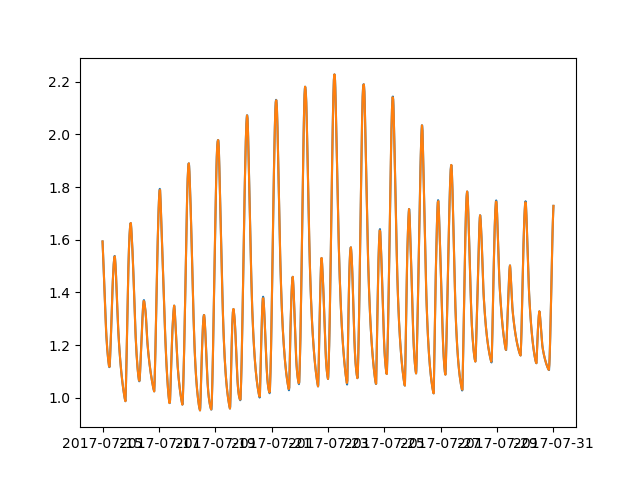

In [22]:
# Map output isn't going to hit the high points too well.
# see if we get lucky, though.
# Not lucky.

plt.figure()
plt.plot(his_ds.time,his_ds.waterlevel.sel(stations='nck'))
plt.plot(map_ds.time, his_ds.waterlevel.sel(stations='nck').sel(time=map_ds.time.values, method='nearest'))

In [26]:
from stompy.grid import multi_ugrid
mu=multi_ugrid.MultiUgrid(model.map_outputs())

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

In [27]:
mu

MultiFile Layer on top of <xarray.Dataset>
Dimensions:                      (Two: 2, mesh2d_nEdges: 9000, mesh2d_nFaces: 5517, mesh2d_nMax_face_nodes: 4, mesh2d_nNodes: 3484, time: 769)
Coordinates:
    mesh2d_node_x                (mesh2d_nNodes) float64 5.525e+05 ... 5.53e+05
    mesh2d_node_y                (mesh2d_nNodes) float64 4.124e+06 ... 4.125e+06
    mesh2d_edge_x                (mesh2d_nEdges) float64 ...
    mesh2d_edge_y                (mesh2d_nEdges) float64 ...
    mesh2d_face_x                (mesh2d_nFaces) float64 5.525e+05 ... 5.53e+05
    mesh2d_face_y                (mesh2d_nFaces) float64 4.124e+06 ... 4.125e+06
  * time                         (time) datetime64[ns] 2017-07-15 ... 2017-07-31
Dimensions without coordinates: Two, mesh2d_nEdges, mesh2d_nFaces, mesh2d_nMax_face_nodes, mesh2d_nNodes
Data variables:
    projected_coordinate_system  int32 ...
    mesh2d                       int32 ...
    mesh2d_node_z                (mesh2d_nNodes) float64 2.252 2.281 

In [74]:
# 1 month at 12h map output is 624M
# To get some inundation maps I really only need the first half of that

# Plot spring high tide:
# Consider max waterlevel around NCK high tide +- 2h.
t_pad=np.timedelta64(2,'h')

def extremum(mu,field,t_min,t_max,maxima=True):
    ti=np.searchsorted(mu.time.values,[t_min,t_max])
    t_slc=slice(ti[0],ti[1])
    tdim=mu[field].dims.index('time')
    values=mu[field].isel(time=ti).values
    if maxima:
        extreme=values.max(axis=tdim)
    else:
        extreme=values.min(axis=tdim)
    return extreme

spring_high_depth=extremum(mu,'mesh2d_waterdepth',spring_high-t_pad,spring_high+t_pad,maxima=True)
spring_low_depth =extremum(mu,'mesh2d_waterdepth',spring_low-t_pad,spring_low+t_pad,maxima=False)
neap_high_depth  =extremum(mu,'mesh2d_waterdepth',neap_high-t_pad,neap_high+t_pad,maxima=True)
neap_low_depth   =extremum(mu,'mesh2d_waterdepth',neap_low-t_pad,neap_low+t_pad,maxima=False)

<IPython.core.display.Javascript object>


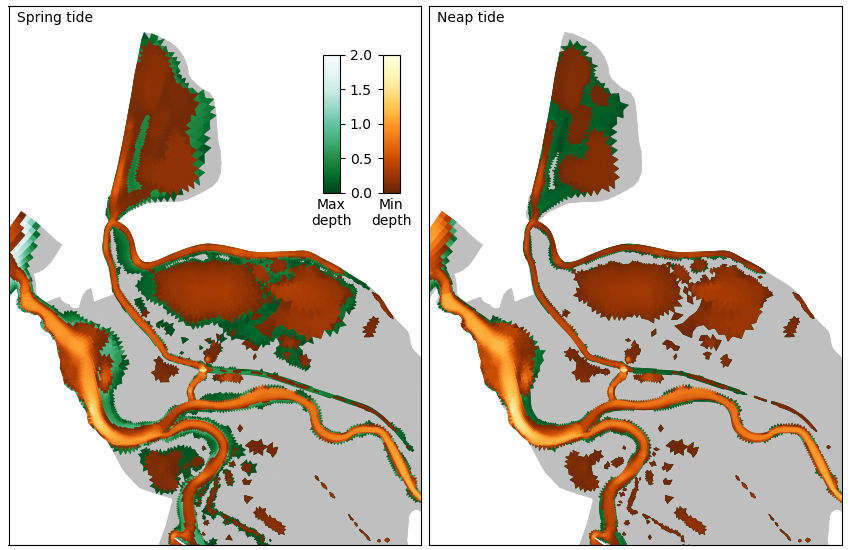

In [75]:
fig,axs=plt.subplots(1,2,figsize=(8.5,5.5))
for ax in axs:
    mu.grid.plot_cells(color="0.75",ax=ax)
    
thresh=0.05
# axs[0] for spring range
mu.grid.plot_cells(mask=spring_high_depth>thresh,ax=axs[0],zorder=1,
                   values=spring_high_depth,cmap='BuGn_r',clim=[0,2.0])
mu.grid.plot_cells(mask=spring_low_depth>thresh,ax=axs[0],zorder=1,
                   values=spring_low_depth,cmap='YlOrBr_r',clim=[0,2.0])
mu.grid.plot_cells(mask=neap_high_depth>thresh,ax=axs[1],zorder=1,
                   values=neap_high_depth,cmap='BuGn_r',clim=[0,2.0])
mu.grid.plot_cells(mask=neap_low_depth>thresh,ax=axs[1],zorder=1,
                   values=neap_low_depth,cmap='YlOrBr_r',clim=[0,2.0])
for ax in axs:
    for coll in ax.collections:
        coll.set_edgecolor('face')
        coll.set_linewidth(0.5)

for ax in axs:
    #ax.axis('off')
    ax.xaxis.set_visible(0)
    ax.yaxis.set_visible(0)
    ax.axis('tight')
    ax.axis('equal')

fig.subplots_adjust(left=0.01,right=0.99,top=0.99,bottom=0.01,wspace=0.02)
zoom=(552054., 553191., 4123985., 4125409.)
for ax in axs:
    ax.axis(zoom)
    
cax1=fig.add_axes([0.38,0.65,0.02,0.25])
cax2=fig.add_axes([0.45,0.65,0.02,0.25])
plt.colorbar(axs[0].collections[1],cax=cax1)
plt.colorbar(axs[0].collections[2],cax=cax2)
#cax2.yaxis.set_visible(0)
cax2.yaxis.tick_left()
plt.setp(cax2.get_yticklabels(),visible=0)
cax1.set_xlabel('Max\ndepth')
cax2.set_xlabel('Min\ndepth')
axs[0].text(0.02,0.97,"Spring tide",transform=axs[0].transAxes)
axs[1].text(0.02,0.97,"Neap tide",transform=axs[1].transAxes)
fig.savefig('spring-neap-inundation.png',dpi=200)

In [148]:
# Animation of where marsh water goes during breach
breach_dir="run_dye_test-v13b"
breach=pesca_base.PescaButano.load(breach_dir)

In [164]:
his.close()

In [165]:
his=breach.his_dataset()

Some lines are degenerate


In [149]:
mu_breach=multi_ugrid.MultiUgrid(breach.map_outputs())

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

In [153]:
mu_breach.reload()

<IPython.core.display.Javascript object>


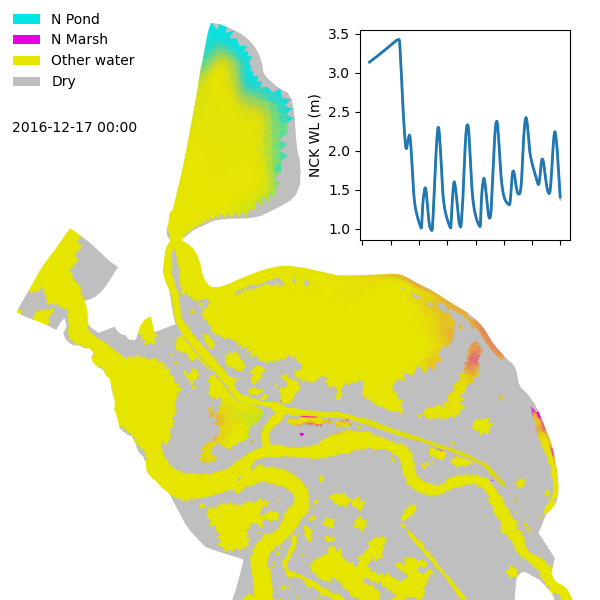

INFO:utils:10/649
INFO:utils:20/649
INFO:utils:29/649
INFO:utils:38/649
INFO:utils:48/649
INFO:utils:57/649
INFO:utils:66/649
INFO:utils:75/649
INFO:utils:83/649
INFO:utils:91/649
INFO:utils:100/649
INFO:utils:109/649
INFO:utils:118/649
INFO:utils:127/649
INFO:utils:136/649
INFO:utils:145/649
INFO:utils:154/649
INFO:utils:162/649
INFO:utils:171/649
INFO:utils:180/649
INFO:utils:189/649
INFO:utils:198/649
INFO:utils:207/649
INFO:utils:216/649
INFO:utils:225/649
INFO:utils:234/649
INFO:utils:243/649
INFO:utils:251/649
INFO:utils:259/649
INFO:utils:268/649
INFO:utils:277/649
INFO:utils:286/649
INFO:utils:295/649
INFO:utils:304/649
INFO:utils:313/649
INFO:utils:322/649
INFO:utils:331/649
INFO:utils:340/649
INFO:utils:349/649
INFO:utils:358/649
INFO:utils:367/649
INFO:utils:376/649
INFO:utils:385/649
INFO:utils:394/649
INFO:utils:403/649
INFO:utils:412/649
INFO:utils:421/649
INFO:utils:430/649
INFO:utils:439/649
INFO:utils:448/649
INFO:utils:457/649
INFO:utils:466/649
INFO:utils:475/649
INF

In [166]:
import os
fig,ax=plt.subplots(figsize=(6,6))
tax=fig.add_axes([0.6,0.6,0.35,0.35])

ccoll=mu_breach.grid.plot_cells(color='0.75',zorder=0,ax=ax)

def to_color(pond,marsh,wet):
    pond=np.asarray(pond)
    marsh=np.asarray(marsh)
    wet=np.asarray(wet)
    other=np.clip(1.0-pond-marsh,0,1)
    r=1-pond
    g=1-marsh
    b=1-other
    colors=0.9*np.array([r,g,b]).T
    colors=wet[...,None]*colors + (1-wet[...,None])*np.ones_like(colors)*0.75
    return colors

fig.subplots_adjust(left=0,right=1,top=1,bottom=0)
ax.axis('off')
ax.axis('tight')
ax.axis('equal')
zoom=(551939., 553342., 4123982., 4125422)

ax.bar(np.nan,np.nan,color=to_color(1,0,True),label='N Pond')
ax.bar(np.nan,np.nan,color=to_color(0,1,True),label='N Marsh')
ax.bar(np.nan,np.nan,color=to_color(0,0,True),label='Other water')
ax.bar(np.nan,np.nan,color=to_color(0,0,False),label='Dry')
ax.legend(loc='upper left',frameon=0)

out_dir="breach-frames-v03"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
for ti in utils.progress(range(mu_breach.dims['time'])):
    tax.cla()
    tax.set_ylabel('NCK WL (m)')
    t=mu_breach.time.values[ti]
    plt.setp(tax.get_xticklabels(),visible=0)
    sel=his.time.values<t
    tax.plot(his.time,his.waterlevel.sel(stations='nck'),color='0.7')
    tax.plot(his.time.values[sel],
             his.waterlevel.sel(stations='nck').values[sel],
             color='tab:blue',lw=2.0)
    wet=(mu_breach['mesh2d_waterdepth'].isel(time=ti).values>0.05)
    pond=mu_breach['mesh2d_pond'].isel(time=ti).values.clip(0,1)
    marsh=mu_breach['mesh2d_marsh'].isel(time=ti).values.clip(0,1)

    ccoll.set_facecolor(to_color(pond,marsh,wet))
    ccoll.set_edgecolor('face')

    ax.texts=[]
    ax.text(0.02,0.78,
            utils.to_datetime(mu_breach.time.values[ti]).strftime('%Y-%m-%d %H:%M'),
            transform=ax.transAxes)
    ax.axis(zoom)
    fig.savefig(os.path.join(out_dir,'breach-%04d.png'%ti))
    fig.canvas.draw()
    plt.pause(0.01)

In [143]:
# Load BML dataset:
import pandas as pd
bml_data_dir="../../data/BML data/2016/all_concatenated"
# Shift to NAVD88 adjusted data:
fn=os.path.join(bml_data_dir,
                '../water_level/elevationNAVD88',
                '2016_NCK_wll_referenced_concat.csv')
df=pd.read_csv(fn)
# UTC
df['time']=pd.to_datetime( df[ ['year','month','day','hour','minute','second']])
df['depth m']=df['NAVD88']
nck_wll=df.set_index('time')
observed=xr.Dataset.from_dataframe(nck_wll)['depth m'].assign_coords(label='NCK wll')

In [130]:
his11=breach.his_dataset()

Some lines are degenerate


In [131]:
# With mod3 bathy
breach12=pesca_base.PescaButano.load("run_dye_test-v12b")
his12=breach12.his_dataset()

In [146]:
# 2016-12-10 breach event
breach13=pesca_base.PescaButano.load("run_dye_test-v13b")
his13=breach13.his_dataset()

Some lines are degenerate


In [137]:
basemod=pesca_base.PescaButano()
qcm=basemod.prep_qcm_data()

INFO:HydroModel:Resampling leads to 295 points for thalweg_pesc
INFO:HydroModel:Resampling leads to 204 points for thalweg_butano
INFO:HydroModel:Bottom interface moved from -0.250 to -0.435 to match deepest node of grid


Setting seepage


<IPython.core.display.Javascript object>


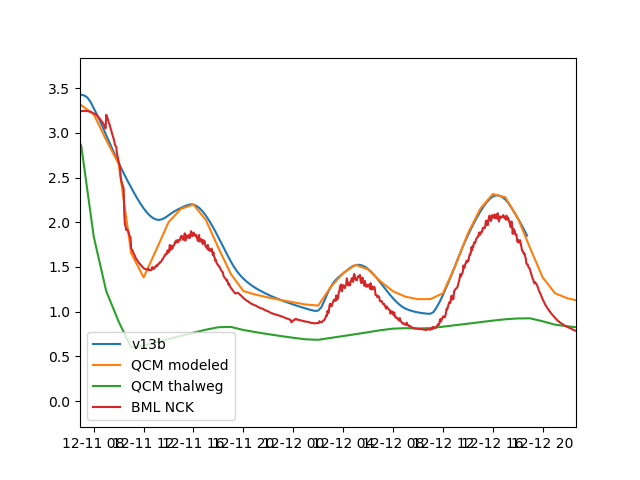

(16865.8354, 16869.5015, -0.03047, 4.1842)

In [147]:
fig,ax=plt.subplots()
ax.plot(his13.time, his13.waterlevel.sel(stations='nck'),label='v13b')
ax.plot(qcm.time, qcm.z_lagoon,label='QCM modeled')
ax.plot(qcm.time, qcm.z_thalweg,label='QCM thalweg')
ax.plot(observed.time,observed,label='BML NCK')
ax.legend(loc='lower left')
ax.axis((16865.8354, 16869.5015, -0.03047, 4.1842))